In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

from scipy import stats
from statistics import mode

import warnings
warnings.filterwarnings('ignore')

import pandas_datareader.data as web
import datetime
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima_model import ARIMA

In [ ]:
def evaluacion (activo,start,pred_size,lags):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval="m")
    df = df[["Close","Volume"]]
    
    df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
    df['log_value'] = np.log(df['Close'])
    df["sqrt"] = np.sqrt(df["Close"])
    df['month'] = [d.strftime('%b') for d in df.index]
    dummies_mes = pd.get_dummies(df['month'],drop_first=True)
    df = df.join(dummies_mes)
    
    df_train, df_test = train_test_split(df, test_size=pred_size, random_state=42, shuffle=False)
    
    model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()
    
    df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


    df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])
    
    df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
    df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])
    res_model = df_train['Close'] - df_train['back_model_log_est']
    res_log_est = df_train['log_value'] - df_train['model_log_est']
    result = adfuller(res_model)
    result1 = adfuller(res_log_est)
    if result[1]<0.05:
        print("elegimos el residuo del precio de cierre - exp(log est) - p=",result[1])
        modelo = res_model
        tsplot (res_model,lags=lags)
        tipo = 1
    elif result1[1]<0.05:
        print("elegimos el residuo del log precio de cierre - log est - p=",result1[1])
        modelo = res_log_est
        tsplot (res_log_est,lags=lags)
        tipo = 2
    else:
        print("la serie no es estacionaria, hacer mas diferenciación")
    return (modelo,df_train,df_test,tipo)

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def arima (modelo,p,d,q,alpha):
    model_ARIMA = ARIMA(modelo[0], order=(p,d,q))
    results_ARIMA = model_ARIMA.fit()
    res_ARIMA =  results_ARIMA.fittedvalues - modelo[0]
    predictions_ARIMA, se, conf = results_ARIMA.forecast(len(modelo[2]['Close']), alpha=alpha)
    if modelo[3] == 1:
        modelo[1]['model_ARIMA'] = modelo[1]['back_model_log_est'] + results_ARIMA.fittedvalues
        modelo[2]['model_ARIMA'] = modelo[2]['back_model_log_est'] + predictions_ARIMA
    else:
        modelo[1]['model_ARIMA'] = np.exp(modelo[1]['model_log_est'] + results_ARIMA.fittedvalues)
        modelo[2]['model_ARIMA'] = np.exp(modelo[2]['model_log_est'] + predictions_ARIMA)
    modelo[1].plot(kind = "line", y = ['Close', 'model_ARIMA']);
    modelo[2].plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [ ]:
modelo = evaluacion("eth-usd","2015, 1, 1",6,20)

In [ ]:
arima(modelo,2,0,2,0.05)

*código para graficar la función y analizar

In [2]:
import os
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models.widgets import Dropdown
from bokeh.io import curdoc
from bokeh.layouts import column

from bokeh.models import BooleanFilter, CDSView, Select, Range1d, HoverTool
from bokeh.palettes import Category20
from bokeh.models.formatters import NumeralTickFormatter
from bokeh.io import output_notebook, show

output_notebook()

Loading BokehJS ...

In [13]:
def get_symbol_df (activo,start,period):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval=period)
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])
    return df

In [54]:
df = get_symbol_df("amzn","2015, 1, 1","m")
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-01-01,359.500000,285.250000,312.579987,354.529999,103057100,354.529999
1,2015-02-01,389.369995,350.010010,350.049988,380.160004,70846200,380.160004
2,2015-03-01,388.420013,365.649994,380.850006,372.100006,55502800,372.100006
3,2015-04-01,452.649994,368.339996,372.100006,421.779999,84404800,421.779999
4,2015-05-01,439.000000,414.549988,423.820007,429.230011,51983000,429.230011
...,...,...,...,...,...,...,...
78,2021-07-01,3773.080078,3306.979980,3434.610107,3327.590088,83720800,3327.590088
79,2021-08-01,3472.580078,3175.760010,3353.100098,3470.790039,62813700,3470.790039
80,2021-09-01,3549.989990,3273.989990,3496.399902,3285.040039,62523700,3285.040039
81,2021-10-01,3325.750000,3176.250000,3289.010010,3288.620117,17565500,3288.620117


In [52]:
# plot basic stock prices
def plot_stock_price(stock):
    p = figure(plot_width=W_PLOT, plot_height=H_PLOT, tools=TOOLS,
               title="Stock price", toolbar_location='above')

    inc = stock.data['Close'] > stock.data['Open']
    dec = stock.data['Open'] > stock.data['Close']
    view_inc = CDSView(source=stock, filters=[BooleanFilter(inc)])
    view_dec = CDSView(source=stock, filters=[BooleanFilter(dec)])

    p.segment(x0='index', x1='index', y0='Low', y1='High', color=RED, source=stock, view=view_inc)
    p.segment(x0='index', x1='index', y0='Low', y1='High', color=GREEN, source=stock, view=view_dec)

    p.vbar(x='index', width=VBAR_WIDTH, top='Open', bottom='Close', fill_color=BLUE, line_color=BLUE,
           source=stock,view=view_inc, name="price")
    p.vbar(x='index', width=VBAR_WIDTH, top='Open', bottom='Close', fill_color=RED, line_color=RED,
           source=stock,view=view_dec, name="price")

    p.legend.location = "top_left"
    p.legend.border_line_alpha = 0
    p.legend.background_fill_alpha = 0
    p.legend.click_policy = "mute"
    
    # map dataframe indices to date strings and use as label overrides
    p.xaxis.major_label_overrides = {i+int(stock.data['index'][0]): date.strftime('%b %d') for i, date in enumerate(pd.to_datetime(stock.data["Date"]))}
    p.xaxis.bounds = (stock.data['index'][0], stock.data['index'][-1])

    # Add more ticks in the plot
    p.x_range.range_padding = 0.05
    p.xaxis.ticker.desired_num_ticks = 40
    p.xaxis.major_label_orientation = 3.14/4
    
    # personalización de moneda
    p.yaxis.formatter = NumeralTickFormatter(format='$ 0,0[.]000')
    
    # Select specific tool for the plot
    price_hover = p.select(dict(type=HoverTool))

    # Choose, which glyphs are active by glyph name
    price_hover.names = ["price"]
    # Creating tooltips
    price_hover.tooltips = [("Datetime", "@Date{%Y-%m-%d}"),
                            ("Open", "@Open{$0,0.00}"),
                            ("Close", "@Close{$0,0.00}"),
                           ("Volume", "@Volume{($ 0.00 a)}")]
    price_hover.formatters={"Date": 'datetime'}

    return p



# Define constants
W_PLOT = 800
H_PLOT = 300
TOOLS = 'pan,wheel_zoom,reset,hover'



VBAR_WIDTH = 0.2
RED = Category20[7][6]
GREEN = Category20[5][4]

BLUE = Category20[3][0]
BLUE_LIGHT = Category20[3][1]

ORANGE = Category20[3][2]
PURPLE = Category20[9][8]
BROWN = Category20[11][10]

stock = ColumnDataSource(
    data=dict(Date=[], Open=[], Close=[], High=[], Low=[],index=[]))
#symbol = 'msft'
#df = get_symbol_df("amzn","2015, 1, 1","m")
stock.data = stock.from_df(df)
elements = list()

# Remeber to add hover in the TOOLS constants 
TOOLS = 'pan,wheel_zoom,hover,reset'





# update_plot()
p_stock = plot_stock_price(stock)

elements.append(p_stock)

curdoc().add_root(column(elements))
curdoc().title = 'Bokeh stocks historical prices'

In [55]:
show(plot_stock_price(stock))

Esto es con MPLFINANCE

In [40]:
pip install --upgrade mplfinance

Note: you may need to restart the kernel to use updated packages.


In [41]:
import mplfinance as mpf

In [43]:
def prueba (activo,start,period):
    tipo = 0
    start = datetime.datetime.strptime(start,"%Y, %m, %d" )
    end = datetime.datetime.now()
    df = web.get_data_yahoo(activo, start, end, interval=period)
    return df

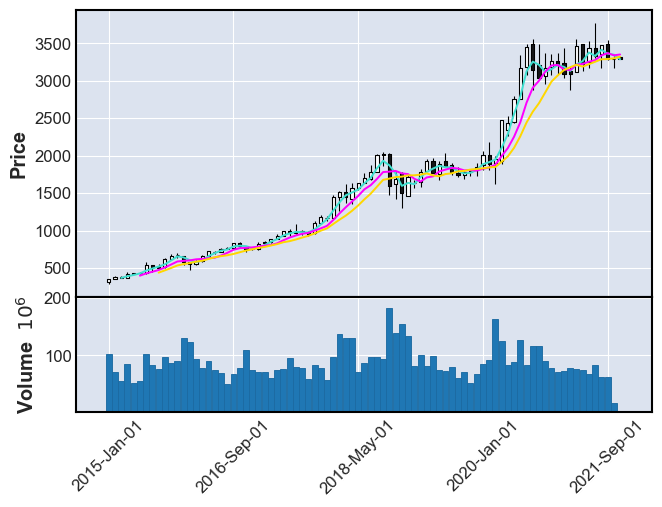

In [56]:
mpf.plot(prueba("amzn","2015, 1, 1","m"),type='candle',mav=(3,6,9),volume=True)

In [ ]:
import yaml

from bokeh.layouts import column
from bokeh.models import ColumnDataSource, Slider
from bokeh.plotting import figure
from bokeh.themes import Theme
from bokeh.io import show, output_notebook

from bokeh.sampledata.sea_surface_temperature import sea_surface_temperature

output_notebook()

#para abajo es codigo repetido o que no utilicé arriba!

In [ ]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.now()
df = web.get_data_yahoo("ko", start, end, interval="m")
df = df[["Close","Volume"]]

In [ ]:
df["timeIndex"] = pd.Series(np.arange(len(df['Close'])), index=df.index)
df['log_value'] = np.log(df['Close'])
df["sqrt"] = np.sqrt(df["Close"])

df['month'] = [d.strftime('%b') for d in df.index]
#df["day"] = [d.strftime('%d') for d in df.index]
dummies_mes = pd.get_dummies(df['month'],drop_first=True)
#dummies_dia = pd.get_dummies(df['day'],drop_first=True,prefix="day")
df = df.join(dummies_mes)
#df = df.join(dummies_dia)


In [ ]:
df.tail()

In [ ]:
df.info()

In [ ]:
# Dividimos en train y test
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=6, random_state=42, shuffle=False)

In [ ]:
model_log_est = smf.ols('log_value ~ timeIndex + Volume + Aug + Dec + Feb + Jan + Jul + Jun + Mar + May + Nov + Oct + Sep ',data = df_train).fit()

In [ ]:
df_train['model_log_est'] = model_log_est.predict(df_train[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])


df_test['model_log_est'] = model_log_est.predict(df_test[["timeIndex", "Volume",\
                                        "Aug", "Dec", "Feb", "Jan","Jul", "Jun", "Mar", "May",\
                                                "Nov", "Oct", "Sep"]])

In [ ]:
# Recuperamos el valor predicho aplicando la función exponencial sobre las predicciones.
df_train['back_model_log_est'] = np.exp(df_train['model_log_est'])
df_test['back_model_log_est'] = np.exp(df_test['model_log_est'])

Resiudos del modelo

In [ ]:
res_model = df_train['Close'] - df_train['back_model_log_est']

plt.plot(df_train.timeIndex, res_model, '-');

In [ ]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_model)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

Residuos del logaritmo

In [ ]:
res_log_est = df_train['log_value'] - df_train['model_log_est']

plt.plot(df_train.timeIndex, res_log_est, '-');

In [ ]:
# Testeamos la estacionariedad de los residuos:

from statsmodels.tsa.stattools import adfuller

result = adfuller(res_log_est)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in  result[4].items():
    print('Valor crítico %s: %.2f' % (key,value))

Residuos de la raiz cuadrada

In [ ]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
lag_acf = acf(res_model, nlags = 20)
lag_acf

In [ ]:
ACF = pd.Series(lag_acf)
ACF.plot(kind = "bar");

In [ ]:
lag_pacf = pacf(res_model, nlags=20, method='ols');

In [ ]:
PACF = pd.Series(lag_pacf)
PACF.plot(kind = "bar");

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """ 
        Plotea la serie de tiempo, el ACF y PACF y el test de Dickey–Fuller
        
        y - serie de tiempo
        lags - cuántos lags incluir para el cálculo de la ACF y PACF
        
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        
        # definimos ejes
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        
        # obtengo el p-value con h0: raiz unitaria presente
        p_value = sm.tsa.stattools.adfuller(y)[1]
        
        ts_ax.set_title('Análisis de la Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'\
                        .format(p_value))
        
        # plot de autocorrelacion
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        # plot de autocorrelacion parcial
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
tsplot(res_model, lags=40)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
model_ARIMA = ARIMA(res_model, order=(2,0,4))

# Estimo el modelo:
results_ARIMA = model_ARIMA.fit()
results_ARIMA.fittedvalues.head()

In [ ]:
print(results_ARIMA.summary())

In [ ]:
plt.figure(figsize=(7,3.5))
res_model.plot()
results_ARIMA.fittedvalues.plot();

In [ ]:
results_ARIMA.plot_predict(end=len(df['Close']));

In [ ]:
res_ARIMA =  results_ARIMA.fittedvalues - res_model

In [ ]:
tsplot(res_ARIMA, lags=20)

In [ ]:
predictions_ARIMA, se, conf = results_ARIMA.forecast(len(df_test['Close']), alpha=0.05)

In [ ]:
df_train['model_ARIMA'] = df_train['back_model_log_est'] + results_ARIMA.fittedvalues

correccion = + df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]

df_test['model_ARIMA'] = df_test['back_model_log_est'] + predictions_ARIMA


In [ ]:
df_train.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual) ** 2
    rmse = np.sqrt(mse.sum() / mse.count())
    return rmse

In [ ]:
df_Results = pd.DataFrame(columns = ["Model", "RMSE"])
df_Results.loc[0, "Model"] = "Model + est + ARIMA"
df_Results.loc[0, "RMSE"] = RMSE(df_test['model_ARIMA'], df_test['Close'])
df_Results

In [ ]:
df_test.plot(kind = "line", y = ['Close', 'model_ARIMA']);

In [ ]:
df_test

In [ ]:
df_train.Close.tail(1)[0] - df_train.model_ARIMA.tail(1)[0]